# TRAIN

In [1]:
from pathlib import Path
from abcnre.simulation import ABCSimulator
from abcnre.simulation.models import create_model_from_dict, get_example_model_configs
import yaml
import logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)
%load_ext autoreload
%autoreload 2

current_dir = Path().resolve() 
parent_dir = current_dir.parent    
results_dir = parent_dir / "results" 

print("--- Step 1: Load model and create simulator ---")
model_name = "g_and_k_default"
model_config = get_example_model_configs(model_name)
model_config["model_args"]["parameter_of_interest"] = "g"  # Set marginal of interest to B
marginal_of_interest = 1


model = create_model_from_dict(model_config)
print(f"Model loaded: {model}")


simulator = ABCSimulator(model=model)

INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'


--- Step 1: Load model and create simulator ---


INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/Users/antoineluciano/.pyenv/versions/3.10.13/lib/libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/Users/antoineluciano/.pyenv/versions/3.10.13/lib/libtpu.so' (no such file), '/opt/homebrew/lib/libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/opt/homebrew/lib/libtpu.so' (no such file), '/Users/antoineluciano/.pyenv/versions/3.10.13/lib/libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/Users/antoineluciano/.pyenv/versions/3.10.13/lib/libtpu.so' (no such file), '/opt/homebrew/lib/libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/opt/homebrew/lib/libtpu.so' (no such file), '/Users/antoineluciano/.pyenv/versions/3.10.13/lib/libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/Users/antoineluciano/

Model loaded: GAndKModel({'model_type': 'GAndKModel', 'model_class': 'GAndKModel', 'model_args': {'prior_bounds': {'A': [0.0, 5.0], 'B': [0.0010000000474974513, 5.0], 'g': [0.0, 5.0], 'k': [0.0, 5.0]}, 'dim': 1, 'n_obs': 100, 'parameter_of_interest': 'g'}})
DEBUG: Summary statistics for data = (100, 1)


INFO:abcnre.simulation.simulator:Created temporary observed data for prior sampling mode


In [2]:
print("--- Step 1.5 : Learn Summary Stats (Optional) ---")

import jax
from abcnre.training import get_nn_config
key = jax.random.PRNGKey(1)
key, subkey_learn = jax.random.split(key)


regressor_config = get_nn_config(network_name="deepset",
                          network_size = "large",
                          training_size = "extended",
                          task_type = "regressor",
                          lr_scheduler_name = "reduce_on_plateau",
                          lr_scheduler_variant = "default",
                          stopping_rules_variant = "balanced",
                          experiment_name = None, 
                          output_dim= 4)


simulator.train_summary_network(subkey_learn, regressor_config)

key, subkey_check = jax.random.split(key)
simulator.check_summary_stats_correlation(
    subkey_check,
    n_samples=10000)

INFO:abcnre.training.config:Set output_dim=4 for regressor


--- Step 1.5 : Learn Summary Stats (Optional) ---


INFO:abcnre.training.config:Using custom lr_scheduler: reduce_on_plateau_default
INFO:abcnre.training.config:Using stopping rules: balanced
INFO:abcnre.training.config:Created NN config: regressor_deepset_large_extended (task: regressor)
INFO:abcnre.training.components.metrics:Configuration Summary:
INFO:abcnre.training.components.metrics:   Task: regressor
INFO:abcnre.training.components.metrics:   Network: DeepSet
INFO:abcnre.training.components.metrics:   Optimizer: adamw
INFO:abcnre.training.components.metrics:   Learning rate: 0.0001
INFO:abcnre.training.components.metrics:   LR scheduler: reduce_on_plateau
INFO:abcnre.training.components.metrics:   Batch size: 512
INFO:abcnre.training.components.metrics:   Samples/epoch: 20480
INFO:abcnre.training.components.metrics:   Max epochs: 200
INFO:abcnre.training.components.metrics:   Stopping rules: Enabled
INFO:abcnre.training.components.setup:Setting up regressor training
INFO:abcnre.training.components.setup:Epochs: 200, Batch size: 

SHapes: input: (1000, 100, 1), output: (1000, 1), n_simulations: 1000


INFO:abcnre.training.registry:Registered networks: MLP, DeepSet, ConditionedDeepSet
INFO:abcnre.training.registry:Created DeepSet network (from 'DeepSet') for regressor
INFO:abcnre.training.registry:Network args: {'activation': 'relu', 'use_layer_norm': True, 'dropout_rate': 0.0, 'pooling_type': 'mean', 'phi_hidden_dims': [64, 64, 32], 'rho_hidden_dims': [64, 64, 32], 'output_dim': 4}
INFO:abcnre.training.components.setup:Created network: DeepSet
INFO:abcnre.training.components.setup:Network initialized with 15,492 parameters
INFO:abcnre.training.components.setup:Using same generator for validation data
INFO:abcnre.training.components.setup:Creating pre-simulated validation set: 10000 samples
INFO:abcnre.training.optimization:Using AdamW with native weight_decay=0.001 support.
INFO:abcnre.training.components.setup:Setup complete. Initial simulations: 10010
INFO:abcnre.training.components.schedulers:Initialized reduce-on-plateau scheduler
INFO:abcnre.training.components.metrics:========

TypeError: Cannot concatenate arrays with shapes that differ in dimensions other than the one being concatenated: concatenating along dimension 0 for shapes (1, 40000), (1, 10000).

In [3]:
n_samples = 1000 
key, subkey = jax.random.split(key)
phi_samples, x_samples = simulator.model.sample_phi_x_multiple(
    subkey, n_samples=n_samples
)
# Compute summary statistics for the generated samples
summary_stats = simulator.summary_stat_fn(x_samples)

In [4]:

print(f'Shapes: phi_samples: {phi_samples.shape}, x_samples: {x_samples.shape}, summary_stats: {summary_stats.shape}')

Shapes: phi_samples: (1000, 1), x_samples: (1000, 100, 1), summary_stats: (1000, 4)


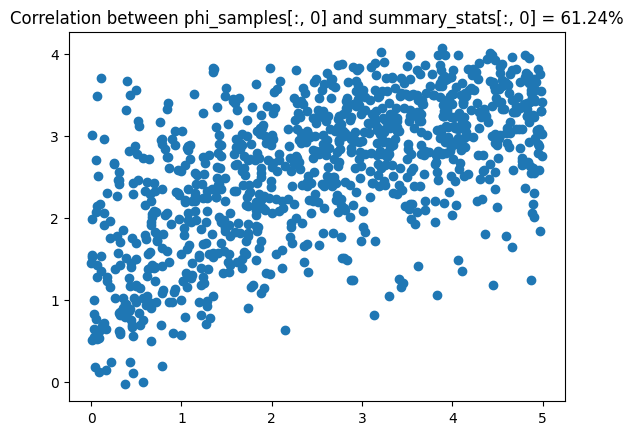

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
import jax.numpy as jnp
for i in range(phi_samples.shape[1]):
    plt.scatter(phi_samples[:,i], summary_stats[:, i])
    plt.title(f'Correlation between phi_samples[:, {i}] and summary_stats[:, {i}] = {jnp.corrcoef(phi_samples[:,i], summary_stats[:, i])[0, 1]:.2%}')
    plt.show()

In [6]:
print("--- Step 2.1: Sample x_obs and initialize the ABCSimulator ---")
import jax.numpy as jnp
model = simulator.model

key, key_prior = jax.random.split(key)
true_theta = model.get_prior_sample(key_prior)

true_theta = jnp.array([3., 1., 2., .5])
true_phi = model.transform_phi(true_theta)

key, subkey_sample = jax.random.split(key)
x_obs = model.simulate_data(subkey_sample, true_theta)

simulator.update_observed_data(x_obs)
print(f"Observation x_obs shape: {x_obs.shape}")



--- Step 2.1: Sample x_obs and initialize the ABCSimulator ---
Observation x_obs shape: (100, 1)


DEBUG: Discrepancy function called with data1 = (4,) data2 = (4,)


INFO:abcnre.simulation.simulator:Computed epsilon = 1.303276 for 50.0% quantile
INFO:abcnre.simulation.simulator:Computed epsilon = 0.265634 for 10.0% quantile
INFO:abcnre.simulation.simulator:Computed epsilon = 0.080644 for 1.0% quantile


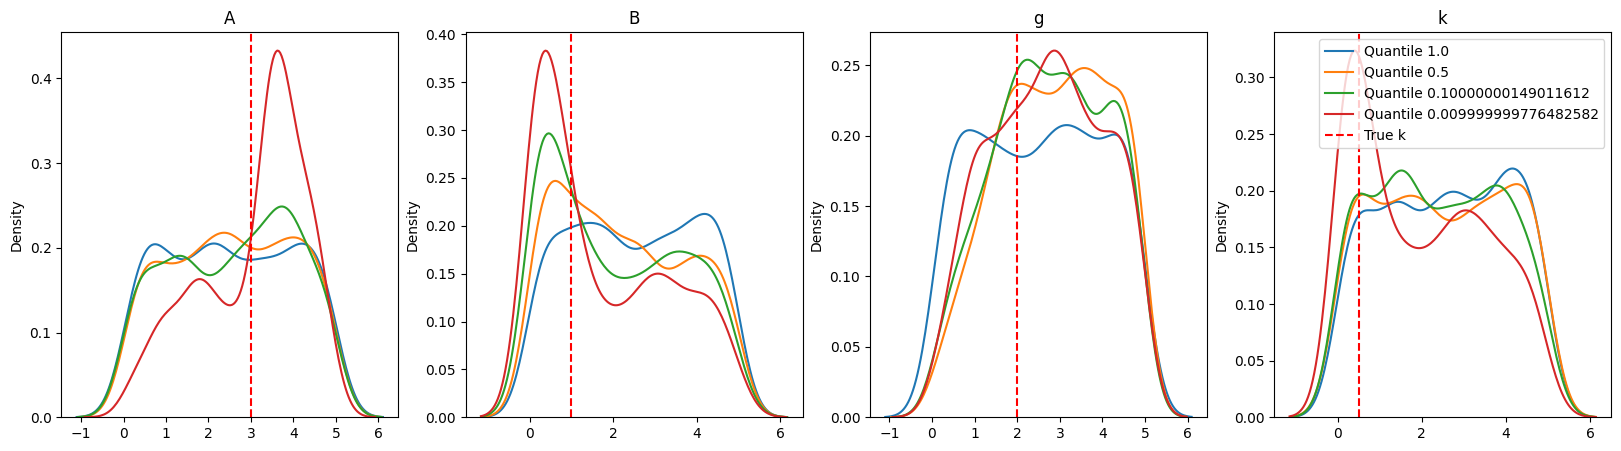

In [7]:
quantiles = jnp.array([1., .5, .1, .01])
import matplotlib.pyplot as plt
import seaborn as sns

f,ax = plt.subplots(1, 4, figsize=(20,5))

for quantile_epsilon in quantiles:

    
    key, subkey_epsilon = jax.random.split(key)
    simulator.set_epsilon_from_quantile(key = subkey_epsilon, quantile_distance=quantile_epsilon, n_samples=10000)
    
    n_samples = 1000
    key, subkey_sample = jax.random.split(key)
    results = simulator.sampler.sample(key=subkey_sample, n_samples=n_samples)
    
    thetas, xs = results.theta, results.data

    sns.kdeplot(thetas[:, 0], ax=ax[0], label=f"Quantile {quantile_epsilon}")
    sns.kdeplot(thetas[:, 1], ax=ax[1], label=f"Quantile {quantile_epsilon}")
    sns.kdeplot(thetas[:, 2], ax=ax[2], label=f"Quantile {quantile_epsilon}")
    sns.kdeplot(thetas[:, 3], ax=ax[3], label=f"Quantile {quantile_epsilon}")


ax[0].set_title("A")
ax[1].set_title("B")
ax[2].set_title("g")
ax[3].set_title("k")
ax[0].axvline(true_theta[0], color='red', linestyle='--', label='True A')
ax[1].axvline(true_theta[1], color='red', linestyle='--', label='True B')
ax[2].axvline(true_theta[2], color='red', linestyle='--', label='True g')
ax[3].axvline(true_theta[3], color='red', linestyle='--', label='True k')
plt.legend()
plt.show()

In [8]:
alpha = 1.
quantile_distance = alpha 
key, subkey_epsilon = jax.random.split(key)
simulator.set_epsilon_from_quantile(key = subkey_epsilon, quantile_distance=quantile_distance, n_samples=10000)

In [9]:
print("--- Step 2.2: Save model to YAML (Optional) ---")

from abcnre.simulation import save_simulator_to_yaml


save_simulator_to_yaml(
    simulator,
    results_dir / "simulator" / "simulator_{}.yaml".format(model_config["model_args"]["parameter_of_interest"]),
    overwrite=True
)

INFO:abcnre.simulation.models.io:Model saved to: /Users/antoineluciano/Documents/Recherche/ABC-SBI-1/abcnre/examples/g_and_K_1D/results/simulator/simulator_g_model.yml
INFO:abcnre.simulation.io:Saved model configuration to: /Users/antoineluciano/Documents/Recherche/ABC-SBI-1/abcnre/examples/g_and_K_1D/results/simulator/simulator_g_model.yml
INFO:abcnre.simulation.io:Saved observed data to: /Users/antoineluciano/Documents/Recherche/ABC-SBI-1/abcnre/examples/g_and_K_1D/results/simulator/simulator_g_observed_data.npy
INFO:abcnre.training.config:Configuration saved to /Users/antoineluciano/Documents/Recherche/ABC-SBI-1/abcnre/examples/g_and_K_1D/results/simulator/simulator_g_summary_network_config.yml
INFO:abcnre.simulation.io:Saved summary network weights to: /Users/antoineluciano/Documents/Recherche/ABC-SBI-1/abcnre/examples/g_and_K_1D/results/simulator/simulator_g_summary_network_weights.npz
INFO:abcnre.simulation.io:ABCSimulator configuration saved to: /Users/antoineluciano/Documents/R

--- Step 2.2: Save model to YAML (Optional) ---


In [10]:

print("--- Step 2.3 : Load model from YAML and check (Optional) ---")

from abcnre.simulation import load_simulator_from_yaml
simulator_loaded = load_simulator_from_yaml(
    results_dir / "simulator" / "simulator_{}.yaml".format(model_config["model_args"]["parameter_of_interest"]),
)

from abcnre.utils.comparison import are_simulators_equivalent

simulators_match = are_simulators_equivalent(simulator, simulator_loaded)
print(f"Simulators match: {'YES' if simulators_match else 'NO'}")

INFO:abcnre.simulation.io:Loaded model: GAndKModel
INFO:abcnre.simulation.io:Loaded observed data from: /Users/antoineluciano/Documents/Recherche/ABC-SBI-1/abcnre/examples/g_and_K_1D/results/simulator/simulator_g_observed_data.npy


--- Step 2.3 : Load model from YAML and check (Optional) ---


INFO:abcnre.simulation.simulator:Using provided epsilon = inf
INFO:abcnre.training.config:Loaded configuration from /Users/antoineluciano/Documents/Recherche/ABC-SBI-1/abcnre/examples/g_and_K_1D/results/simulator/simulator_g_summary_network_config.yml
INFO:abcnre.simulation.io:Loaded summary network config from: /Users/antoineluciano/Documents/Recherche/ABC-SBI-1/abcnre/examples/g_and_K_1D/results/simulator/simulator_g_summary_network_config.yml
INFO:abcnre.simulation.io:Loaded summary network weights from: /Users/antoineluciano/Documents/Recherche/ABC-SBI-1/abcnre/examples/g_and_K_1D/results/simulator/simulator_g_summary_network_weights.npz
INFO:abcnre.training.registry:Registered networks: MLP, DeepSet, ConditionedDeepSet
INFO:abcnre.training.registry:Created DeepSet network (from 'DeepSet') for regressor
INFO:abcnre.training.registry:Network args: {'activation': 'relu', 'use_layer_norm': True, 'dropout_rate': 0.0, 'pooling_type': 'mean', 'phi_hidden_dims': [64, 64, 32], 'rho_hidden_

DEBUG: Summary statistics for data = (100, 1)
Simulators match: YES


In [11]:
from abcnre.training import NNConfig, NetworkConfig, TrainingConfig, get_nn_config
print("--- Step 3.1: Create NNConfig for training ---")
nn_config = get_nn_config(network_name="conditioned_deepset",
                          network_size = "large",
                          training_size = "extended",
                          task_type = "classifier",
                          lr_scheduler_name = "reduce_on_plateau",
                          lr_scheduler_variant = "default",
                          stopping_rules_variant = "balanced",
                          experiment_name = None)

INFO:abcnre.training.config:Using custom lr_scheduler: reduce_on_plateau_default
INFO:abcnre.training.config:Using stopping rules: balanced
INFO:abcnre.training.config:Created NN config: classifier_conditioned_deepset_large_extended (task: classifier)


--- Step 3.1: Create NNConfig for training ---


In [12]:
print("--- Step 3.2: Create NeuralRatioEstimator ---")

from abcnre.inference import NeuralRatioEstimator    

estimator = NeuralRatioEstimator(
    nn_config=nn_config,
    simulator=simulator)

--- Step 3.2: Create NeuralRatioEstimator ---


In [13]:
print("--- Step 3.3: Train the NeuralRatioEstimator ---")


key, key_train = jax.random.split(key)
res = estimator.train(key_train, n_phi_to_store = 10000)  # Store few phi samples

--- Step 3.3: Train the NeuralRatioEstimator ---


INFO:abcnre.inference.estimator:Using ConditionedDeepSet without summary statistics
INFO:abcnre.inference.estimator:Storing 10000 phi during training
INFO:abcnre.training.components.metrics:Configuration Summary:
INFO:abcnre.training.components.metrics:   Task: classifier
INFO:abcnre.training.components.metrics:   Network: ConditionedDeepSet
INFO:abcnre.training.components.metrics:   Optimizer: adamw
INFO:abcnre.training.components.metrics:   Learning rate: 0.0001
INFO:abcnre.training.components.metrics:   LR scheduler: reduce_on_plateau
INFO:abcnre.training.components.metrics:   Batch size: 512
INFO:abcnre.training.components.metrics:   Samples/epoch: 20480
INFO:abcnre.training.components.metrics:   Max epochs: 200
INFO:abcnre.training.components.metrics:   Stopping rules: Enabled
INFO:abcnre.training.components.metrics:   Phi storage: 10000 values
INFO:abcnre.training.components.setup:Setting up classifier training
INFO:abcnre.training.components.setup:Epochs: 200, Batch size: 512, B

dict_keys(['x', 'theta'])
DEBUG io samples : input  x=(10000, 100, 1) input theta=(10000, 1), output=(10000,), n_simulations=5000


INFO:abcnre.training.registry:Registered networks: MLP, DeepSet, ConditionedDeepSet
INFO:abcnre.training.registry:Created ConditionedDeepSet network (from 'ConditionedDeepSet') for classifier
INFO:abcnre.training.registry:Network args: {'activation': 'relu', 'use_layer_norm': True, 'dropout_rate': 0.0, 'pooling_type': 'mean', 'conditioning_mode': 'concat', 'phi_hidden_dims': [64, 64, 32], 'rho_hidden_dims': [64, 64, 32], 'output_dim': 1}
INFO:abcnre.training.components.setup:Created network: ConditionedDeepSet
INFO:abcnre.training.components.setup:Network initialized with 15,521 parameters
INFO:abcnre.training.components.setup:Using same generator for validation data
INFO:abcnre.training.components.setup:Creating pre-simulated validation set: 10000 samples
INFO:abcnre.training.optimization:Using AdamW with native weight_decay=0.001 support.
INFO:abcnre.training.components.setup:Setup complete. Initial simulations: 5005
INFO:abcnre.training.components.schedulers:Initialized reduce-on-pl

Neural Ratio Estimator training completed successfully!
   - Final train loss: 0.6205070614814758
   - Total simulations: 1541005


In [14]:
print("--- Step 3.4: Save the NeuralRatioEstimator to YAML (Optional) ---")

from abcnre.inference.io import save_estimator_to_yaml
save_estimator_to_yaml(
    estimator,
    results_dir / "estimator" / f"estimator_{model_config['model_args']['parameter_of_interest']}_quantile_{quantile_distance}.yaml",
    overwrite=True
)


INFO:abcnre.training.config:Configuration saved to /Users/antoineluciano/Documents/Recherche/ABC-SBI-1/abcnre/examples/g_and_K_1D/results/estimator/estimator_g_quantile_1.0_classif_config.yaml
INFO:abcnre.inference.io:Saved classifier config to: /Users/antoineluciano/Documents/Recherche/ABC-SBI-1/abcnre/examples/g_and_K_1D/results/estimator/estimator_g_quantile_1.0_classif_config.yaml
INFO:abcnre.simulation.models.io:Model saved to: /Users/antoineluciano/Documents/Recherche/ABC-SBI-1/abcnre/examples/g_and_K_1D/results/estimator/estimator_g_quantile_1.0_simulator_model.yml
INFO:abcnre.simulation.io:Saved model configuration to: /Users/antoineluciano/Documents/Recherche/ABC-SBI-1/abcnre/examples/g_and_K_1D/results/estimator/estimator_g_quantile_1.0_simulator_model.yml
INFO:abcnre.simulation.io:Saved observed data to: /Users/antoineluciano/Documents/Recherche/ABC-SBI-1/abcnre/examples/g_and_K_1D/results/estimator/estimator_g_quantile_1.0_simulator_observed_data.npy
INFO:abcnre.training.co

--- Step 3.4: Save the NeuralRatioEstimator to YAML (Optional) ---


In [ ]:
print("--- Step 3.5: Load the NeuralRatioEstimator from YAML and check (Optional) ---")

from abcnre.inference import load_estimator_from_yaml

estimator_loaded = load_estimator_from_yaml(
    results_dir / "estimator" / f"estimator_{model_config['model_args']['parameter_of_interest']}_quantile_{quantile_distance}.yaml"
)
from abcnre.utils.comparison import are_estimators_equivalent

estimators_match = are_estimators_equivalent(estimator, estimator_loaded)
print(f"Estimators match: {'YES' if estimators_match else 'NO'}")

INFO:abcnre.training.config:Loaded configuration from /Users/antoineluciano/Documents/Recherche/ABC-SBI-1/abcnre/examples/g_and_K_1D/results/estimator/estimator_all_quantile_1.0_classif_config.yaml
INFO:abcnre.simulation.io:Loaded model: GAndKModel
INFO:abcnre.simulation.io:Loaded observed data from: /Users/antoineluciano/Documents/Recherche/ABC-SBI-1/abcnre/examples/g_and_K_1D/results/estimator/estimator_all_quantile_1.0_simulator_observed_data.npy
INFO:abcnre.simulation.simulator:Using provided epsilon = inf
INFO:abcnre.training.config:Loaded configuration from /Users/antoineluciano/Documents/Recherche/ABC-SBI-1/abcnre/examples/g_and_K_1D/results/estimator/estimator_all_quantile_1.0_simulator_summary_network_config.yml
INFO:abcnre.simulation.io:Loaded summary network config from: /Users/antoineluciano/Documents/Recherche/ABC-SBI-1/abcnre/examples/g_and_K_1D/results/estimator/estimator_all_quantile_1.0_simulator_summary_network_config.yml
INFO:abcnre.simulation.io:Loaded summary netwo

--- Step 3.5: Load the NeuralRatioEstimator from YAML and check (Optional) ---
DEBUG: Summary statistics for data = (100, 1)
Estimators match: YES


# MCMC

In [ ]:
from abcnre.diagnostics.posterior import get_unnormalized_nre_logpdf, get_unnormalized_corrected_nre_logpdf
from abcnre.diagnostics.viz import plot_mcmc_output
from abcnre.diagnostics.mcmc import run_metropolis, get_tuned_covariance, estimate_effective_sample_size

nre_logpdf = get_unnormalized_nre_logpdf(estimator)

correct_nre_logpdf = get_unnormalized_corrected_nre_logpdf(estimator)

key, subkey_cov = jax.random.split(key)
naive_init = jnp.ones(4) * 0.25
nre_tuning = get_tuned_covariance(key = subkey_cov, logpdf_unnorm = nre_logpdf, initial_state = naive_init, n_tuning_samples=10000)

key, subkey_mcmc = jax.random.split(key)
nre_mcmc = run_metropolis(key = subkey_mcmc, logpdf_unnorm=nre_logpdf, initial_state = naive_init, covariance_matrix = nre_tuning.optimal_covariance, n_samples=50000)


key, subkey_cov = jax.random.split(key)
corrected_nre_tuning = get_tuned_covariance(key = subkey_cov, logpdf_unnorm = correct_nre_logpdf, initial_state = naive_init, n_tuning_samples=10000)


key, subkey_mcmc = jax.random.split(key)
correct_nre_mcmc = run_metropolis(key = subkey_mcmc, logpdf_unnorm=correct_nre_logpdf, initial_state = naive_init, covariance_matrix = corrected_nre_tuning.optimal_covariance, n_samples=50000)


true_logpdf = lambda theta: loglikelihood_gandk_newton(x_obs, theta)

key, subkey_cov = jax.random.split(key)
true_tuning = get_tuned_covariance(key = subkey_cov, logpdf_unnorm = true_logpdf, initial_state = naive_init, n_tuning_samples=10000)

key, subkey_mcmc = jax.random.split(key)
true_mcmc = run_metropolis(key = subkey_mcmc, logpdf_unnorm=true_logpdf, initial_state = naive_init, covariance_matrix = true_tuning.optimal_covariance, n_samples=50000)

INFO:abcnre.diagnostics.mcmc:Robbins-Monro tuning with 10000 samples
INFO:abcnre.diagnostics.mcmc:Target acceptance rate: 0.234
INFO:abcnre.diagnostics.mcmc:Target acceptance rate: 0.234
INFO:abcnre.diagnostics.mcmc:Empirical covariance from 500 preliminary samples
INFO:abcnre.diagnostics.mcmc:Empirical covariance from 500 preliminary samples
INFO:abcnre.diagnostics.mcmc:Phase 1/15, scale: 1.0000, acceptance: 0.251, step_size: 1.0000
INFO:abcnre.diagnostics.mcmc:Phase 1/15, scale: 1.0000, acceptance: 0.251, step_size: 1.0000
INFO:abcnre.diagnostics.mcmc:Phase 4/15, scale: 0.9008, acceptance: 0.179, step_size: 0.4353
INFO:abcnre.diagnostics.mcmc:Phase 4/15, scale: 0.9008, acceptance: 0.179, step_size: 0.4353
INFO:abcnre.diagnostics.mcmc:Phase 7/15, scale: 0.8616, acceptance: 0.251, step_size: 0.3111
INFO:abcnre.diagnostics.mcmc:Phase 7/15, scale: 0.8616, acceptance: 0.251, step_size: 0.3111
INFO:abcnre.diagnostics.mcmc:Phase 10/15, scale: 0.8562, acceptance: 0.215, step_size: 0.2512
INF

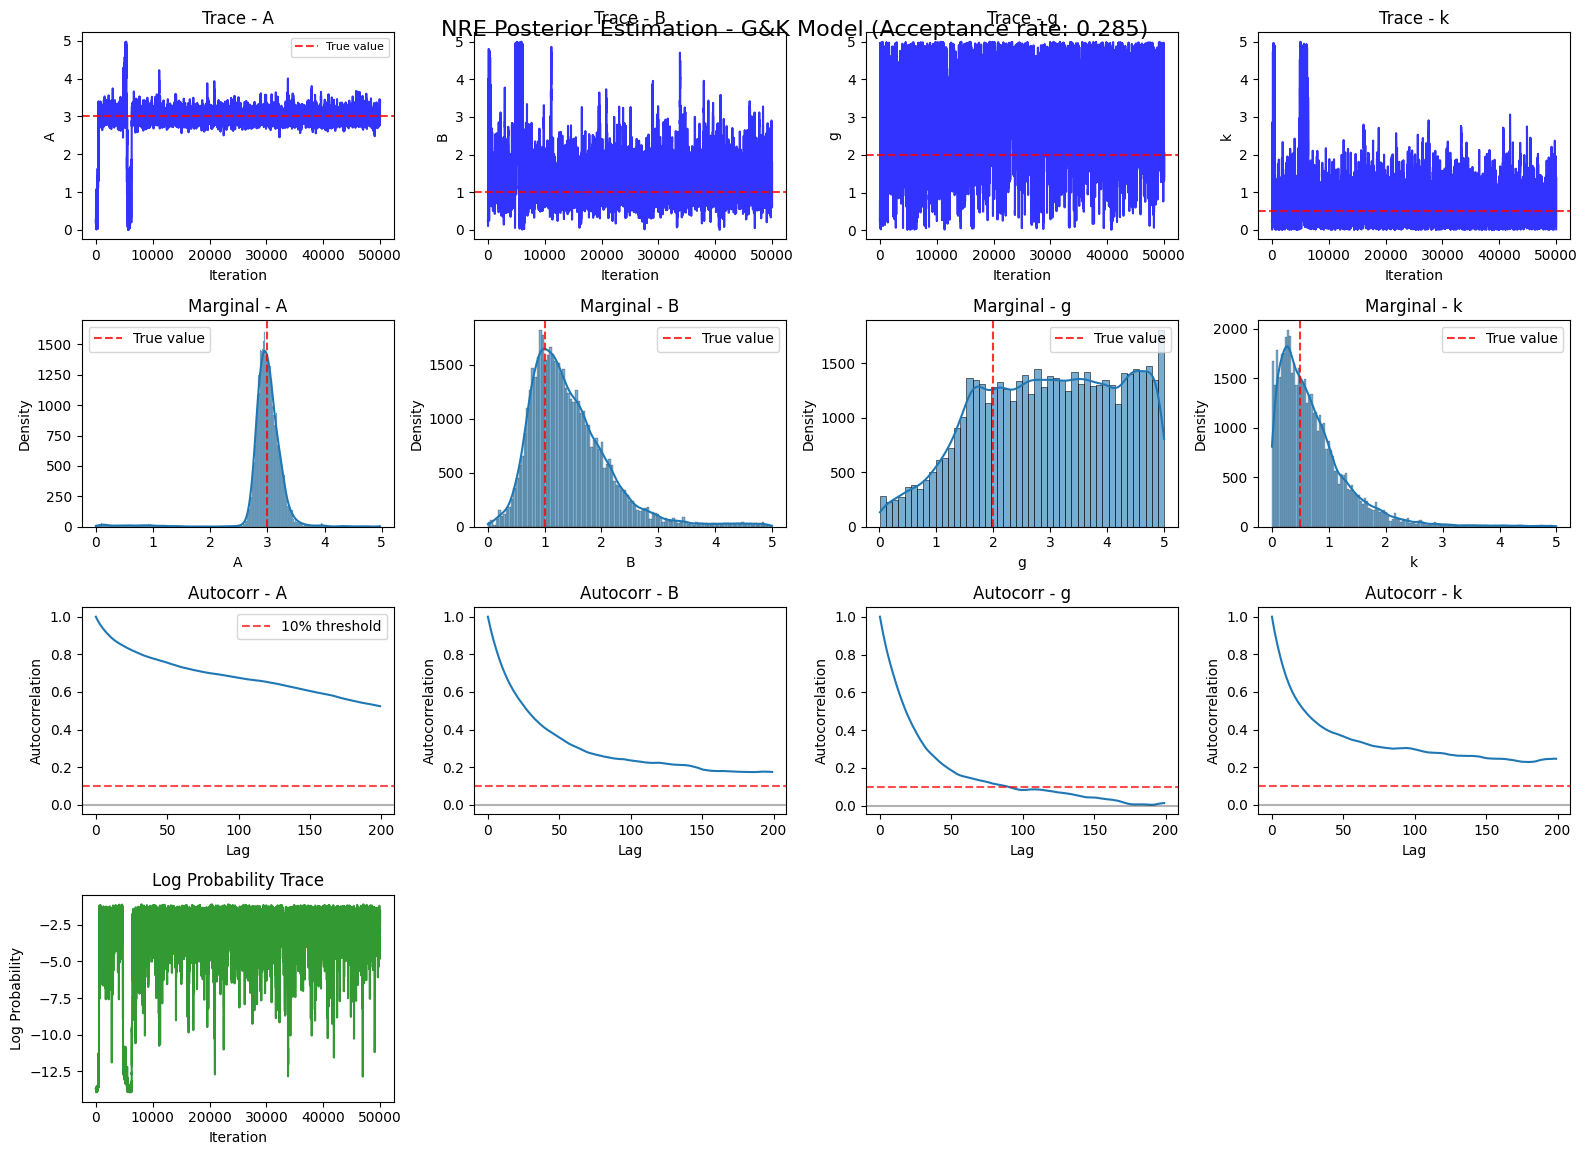

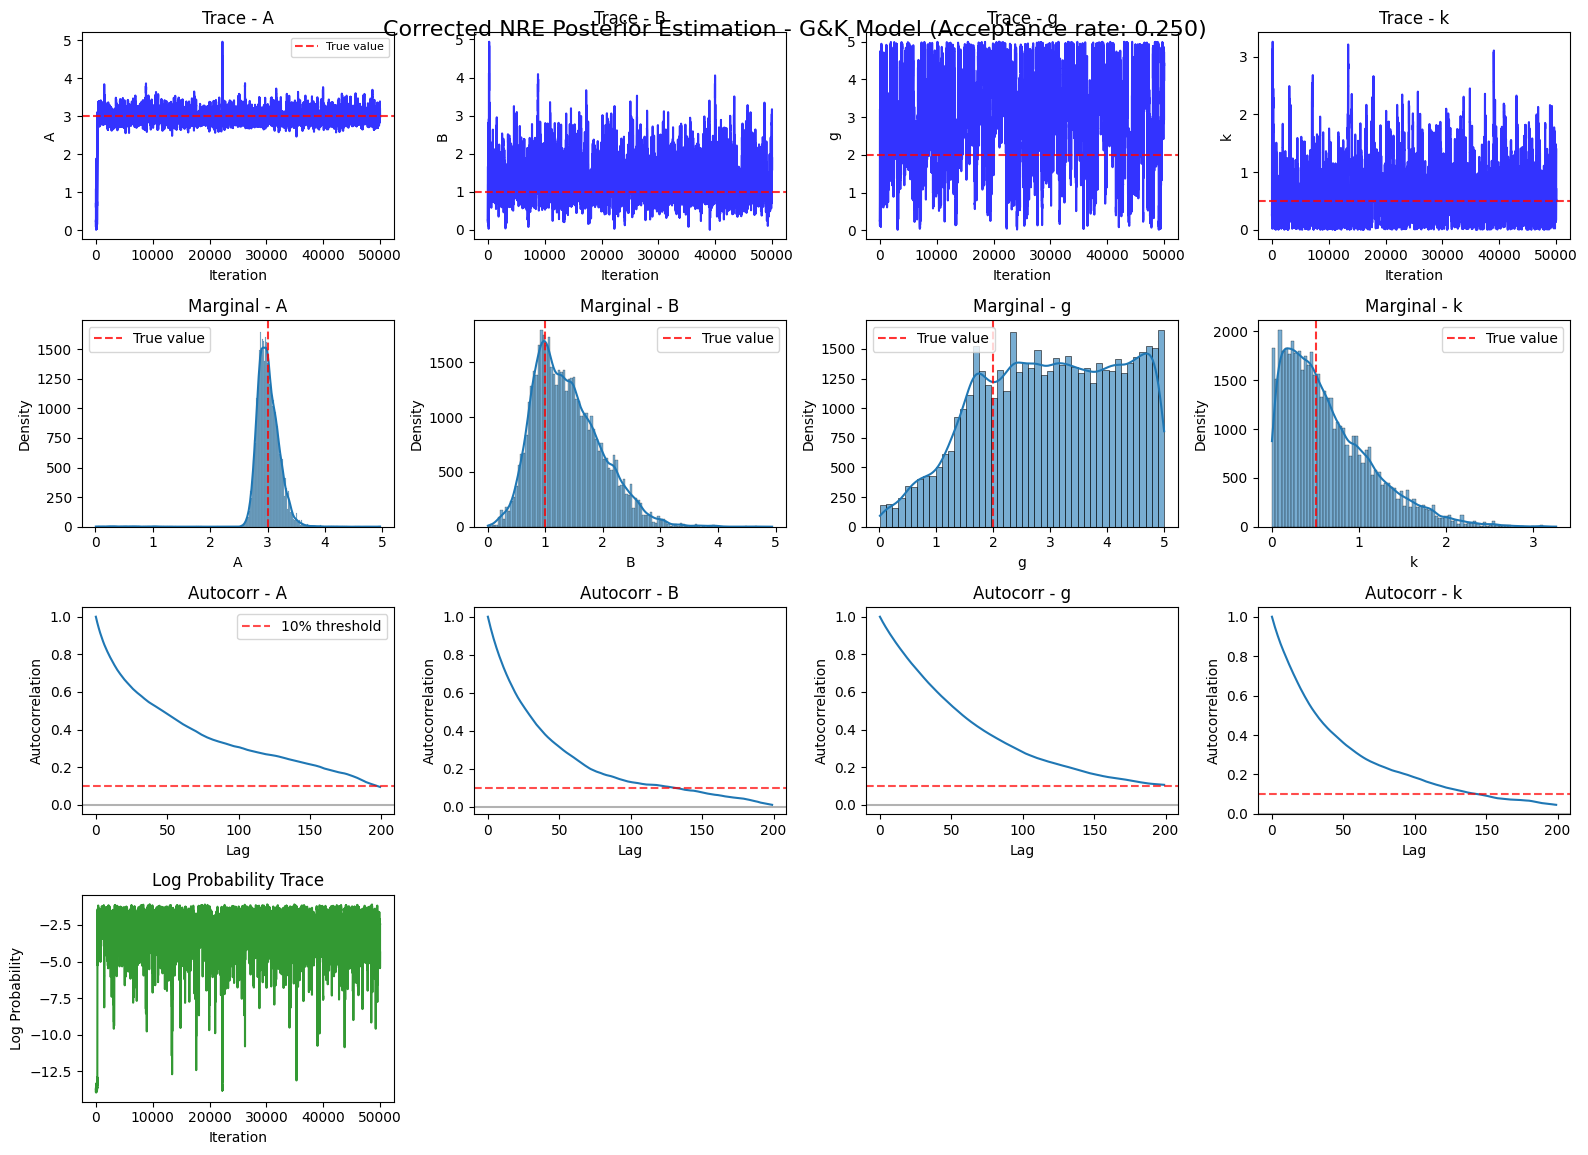

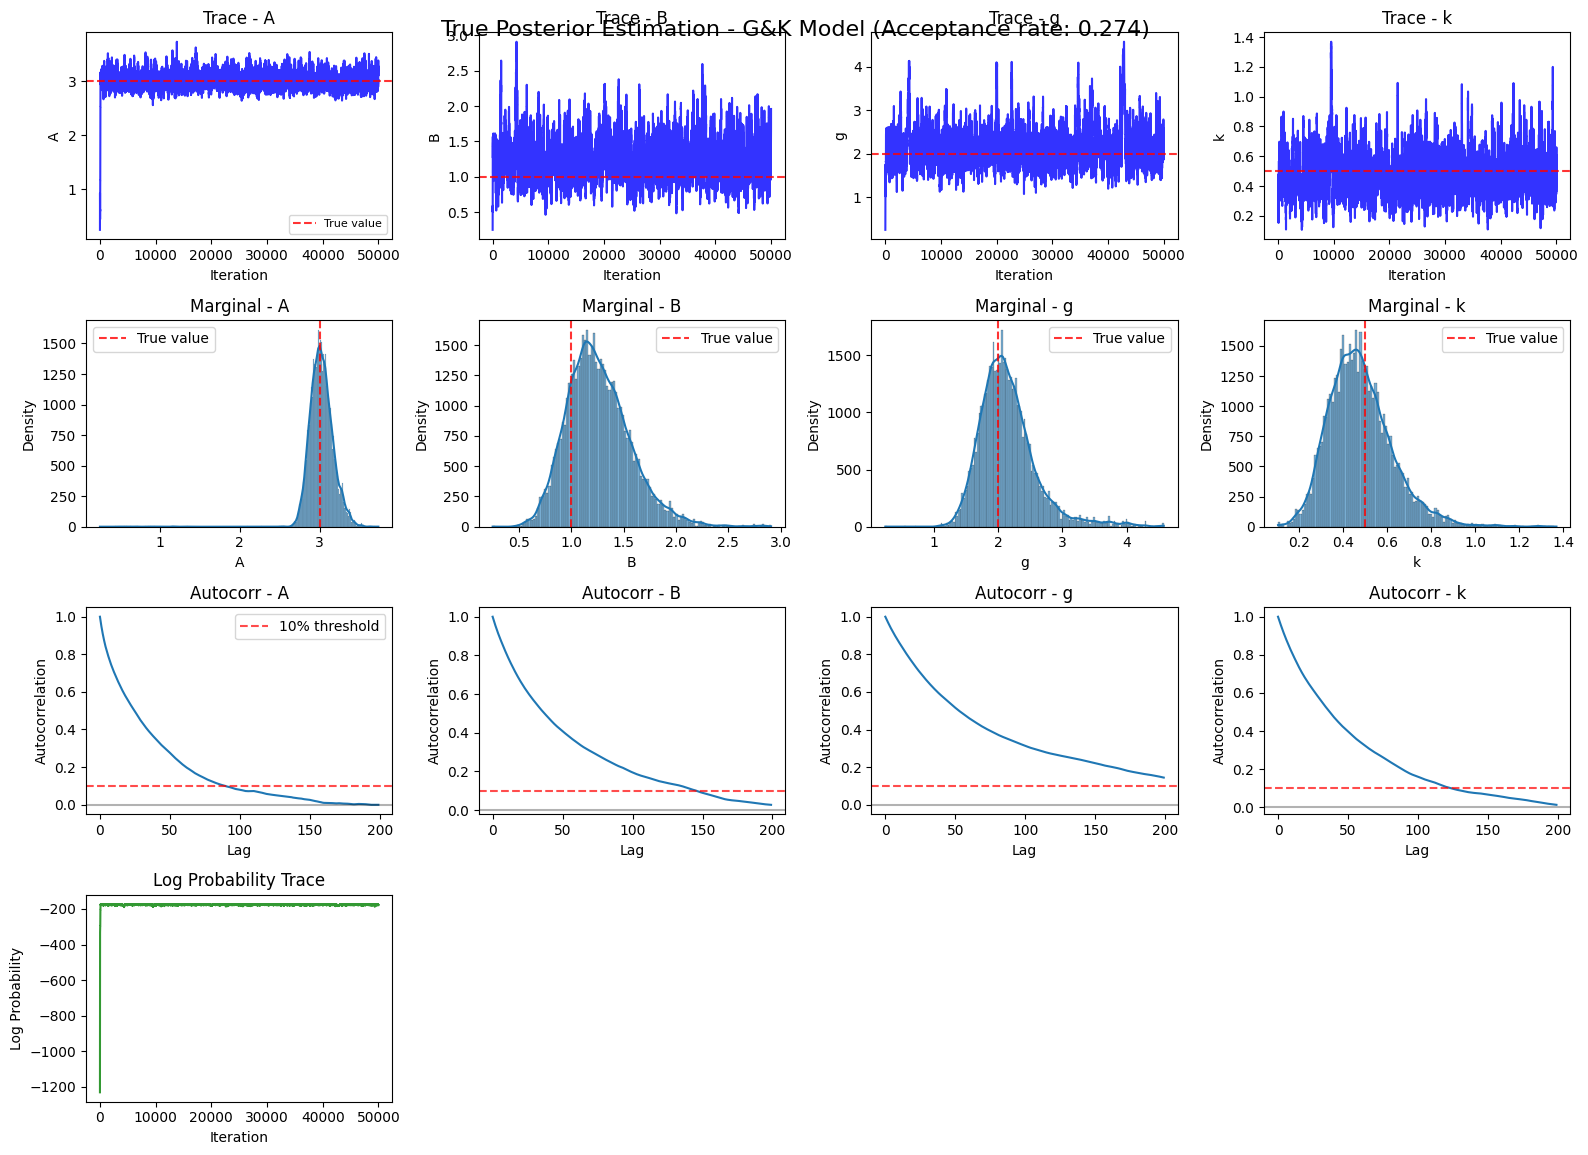

In [128]:

plot_mcmc_output(
    mcmc_results=nre_mcmc,
    true_values=true_theta, 
    parameter_names=['A', 'B', 'g', 'k'],
    title="NRE Posterior Estimation - G&K Model",
    figsize=(16, 12)
)

plot_mcmc_output(
    mcmc_results=correct_nre_mcmc,
    true_values=true_theta, 
    parameter_names=['A', 'B', 'g', 'k'],
    title="Corrected NRE Posterior Estimation - G&K Model",
    figsize=(16, 12)
)

plot_mcmc_output(
    mcmc_results=true_mcmc,
    true_values=true_theta, 
    parameter_names=['A', 'B', 'g', 'k'],
    title="True Posterior Estimation - G&K Model",
    figsize=(16, 12)
)



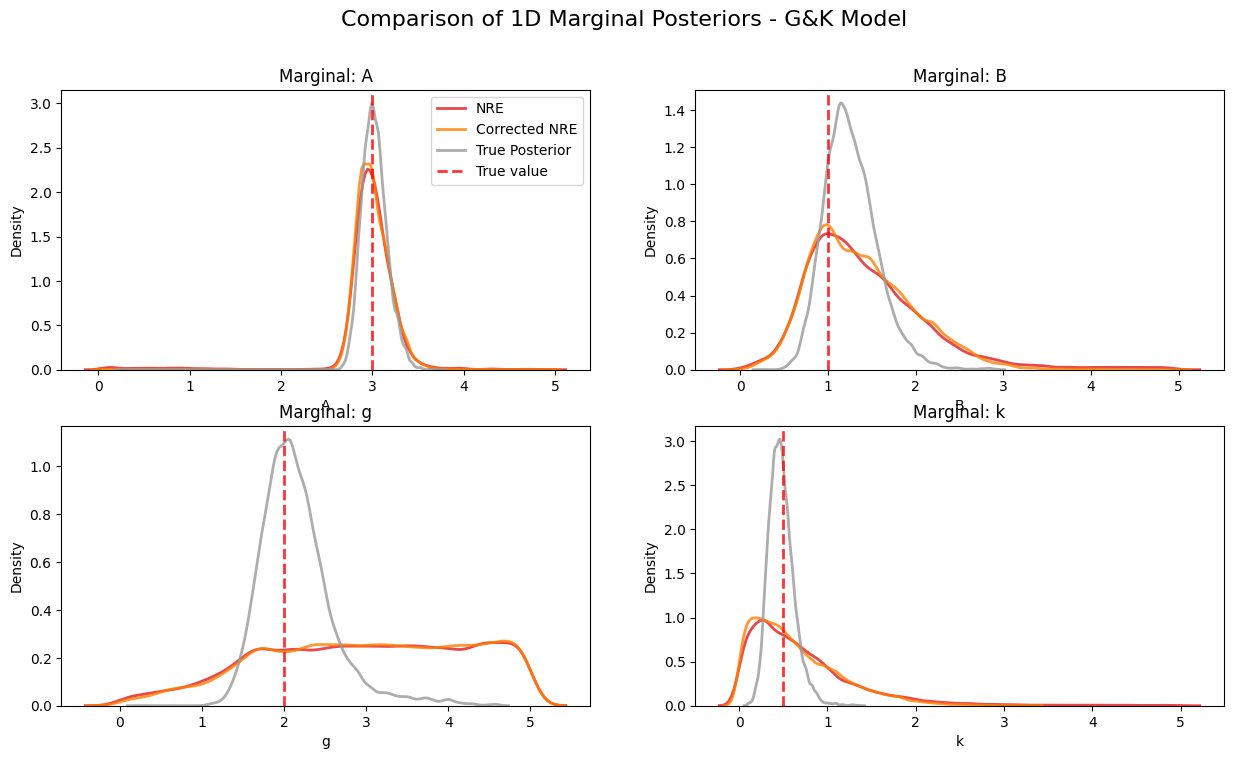

/Users/antoineluciano/.pyenv/versions/jax_env/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


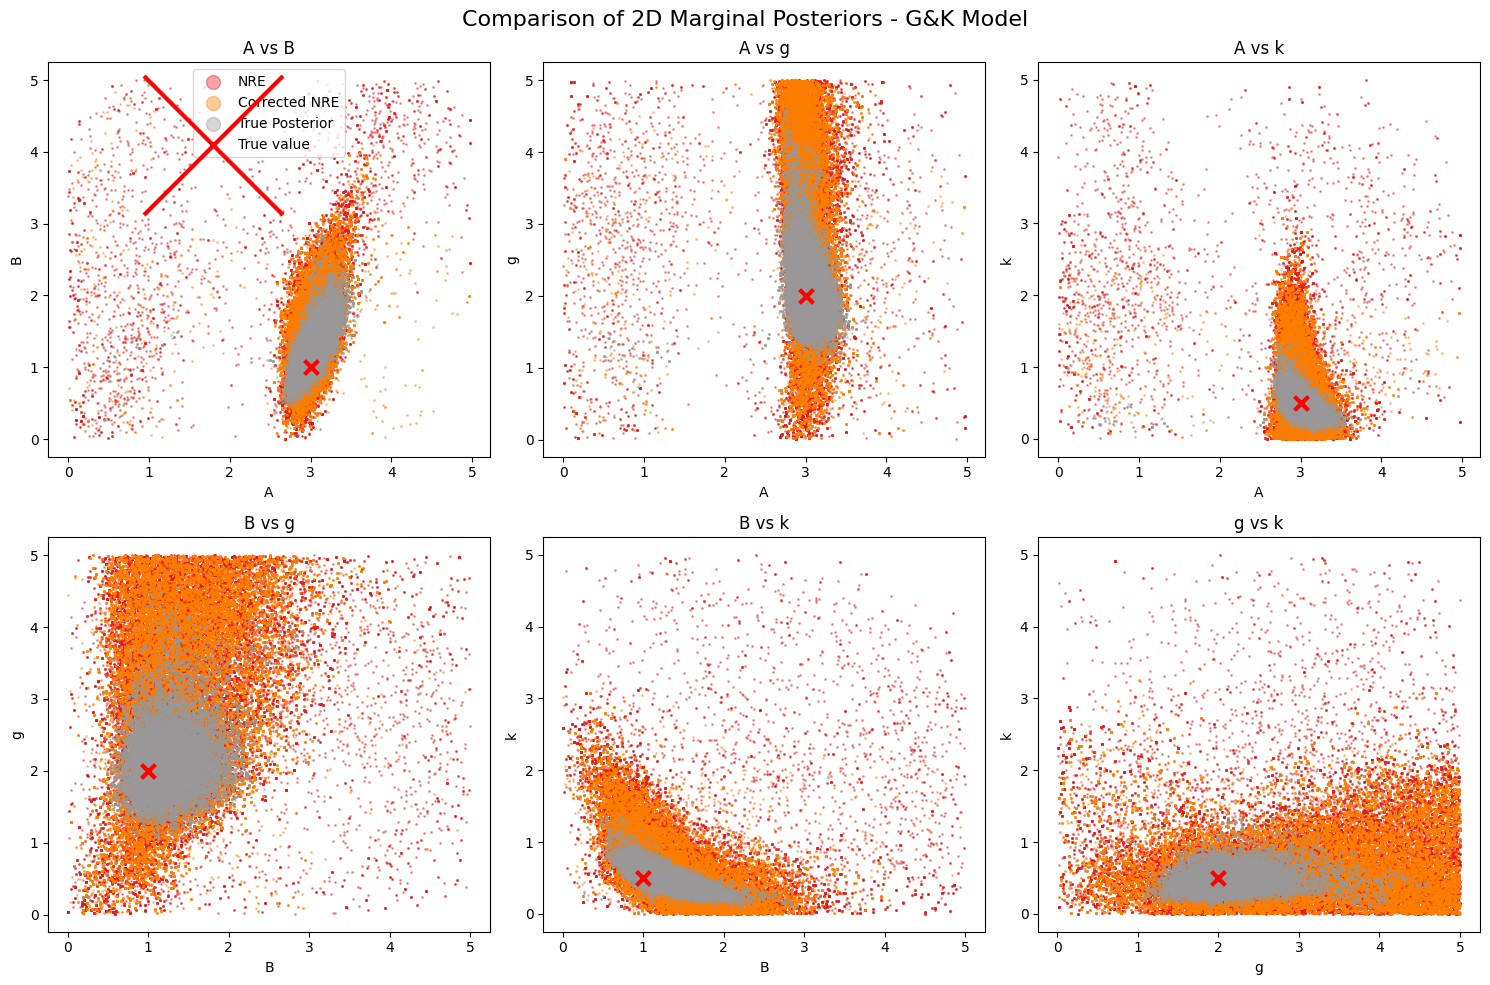

In [129]:
# Test des nouvelles fonctions de comparaison marginale
from abcnre.diagnostics.viz import plot_1D_marginal_comparison, plot_2D_marginal_comparison


# Préparer les données pour comparaison (seulement MCMC compatible)
samples_comparison = {
    'NRE': nre_mcmc.samples,
    'Corrected NRE': correct_nre_mcmc.samples, 
    'True Posterior': true_mcmc.samples
}


plot_1D_marginal_comparison(
    samples_dict=samples_comparison,
    parameter_names=['A', 'B', 'g', 'k'],
    true_values=true_theta,
    title="Comparison of 1D Marginal Posteriors - G&K Model"
)

plot_2D_marginal_comparison(
    samples_dict=samples_comparison,
    parameter_names=['A', 'B', 'g', 'k'],
    true_values=true_theta,
    title="Comparison of 2D Marginal Posteriors - G&K Model",
    alpha=0.4  
)


In [104]:
import jax
from jax import jit
import jax.scipy.stats as jax_stats

@jit
def Q_of_u(u, theta):
    a, b, g, k = theta  # Même convention que Q_of_z
    
    z = jax_stats.norm.ppf(u)
    tanh_term = jnp.tanh(g * z / 2)
    quantile = a + b * (1 + .8 * tanh_term) * jnp.power(1 + z**2, k) * z
    
    return quantile

def get_Q_grids(theta, n_points=1000):
    u_grid = jnp.linspace(1e-6, 1-1e-6, n_points)
    q_grid = Q_of_u(u_grid, theta)
    return u_grid, q_grid

@jit
def pdf_from_cdf_finite_diff(x, u_grid, q_grid, dx=1e-4):
    # S'assurer que x est un scalaire
    x_scalar = jnp.squeeze(x)
    cdf_x_plus = jnp.interp(x_scalar + dx/2, q_grid, u_grid)
    cdf_x_minus = jnp.interp(x_scalar - dx/2, q_grid, u_grid)
    return (cdf_x_plus - cdf_x_minus) / dx

pdf_from_cdf_finite_diff_vectorized = jax.jit(jax.vmap(pdf_from_cdf_finite_diff, in_axes=(0, None, None)))

def lik_from_xobs_grid(x_obs, theta, n_points=1000):

    u_grid, q_grid = get_Q_grids(theta, n_points=n_points)
    pdf_values = pdf_from_cdf_finite_diff_vectorized(x_obs, u_grid, q_grid)
    return jnp.prod(jnp.array(pdf_values))



In [ ]:
import jax
import jax.numpy as jnp
from jax import lax

# Constantes
LOG2PI = jnp.log(2.0 * jnp.pi)

# Fonctions auxiliaires G&K optimisées
@jax.jit
def _A(z, g):
    return 1.0 + 0.8 * jnp.tanh(0.5 * g * z)

@jax.jit
def _dA(z, g):
    u = 0.5 * g * z
    return 0.4 * g * (1.0 / jnp.cosh(u))**2

@jax.jit
def _H(z, k):
    return (1.0 + z**2)**k

@jax.jit
def _dH(z, k):
    return 2.0 * k * z * (1.0 + z**2)**(k - 1.0)

@jax.jit
def Q_of_z(z, theta):
    a, b, g, k = theta
    return a + b * _A(z, g) * _H(z, k) * z

@jax.jit
def dQdz(z, theta):
    a, b, g, k = theta
    A, H = _A(z, g), _H(z, k)
    dA, dH = _dA(z, g), _dH(z, k)
    return b * (A * H + A * z * dH + H * z * dA)

@jax.jit
def solve_z_for_x(x, theta, z_min=-8.0, z_max=8.0, newton_steps=25, bisect_steps=35):
    x_scalar = jnp.squeeze(x)
    
    # Bornes de l'intervalle
    q_lo = Q_of_z(z_min, theta)
    q_hi = Q_of_z(z_max, theta)
    
    # Cas limites
    def _return_low(_): return z_min
    def _return_high(_): return z_max
    
    def _solve(_):
        a, b, g, k = theta
        # Initialisation intelligente
        z0 = jnp.clip((x_scalar - a) / jnp.maximum(jnp.abs(b), 1e-8), z_min, z_max)
        z_lo, z_hi, z = z_min, z_max, z0
        
        # Phase Newton-Raphson avec fallback bissection
        def newton_body(carry, _):
            z_lo, z_hi, z = carry
            f = Q_of_z(z, theta) - x_scalar
            df = dQdz(z, theta)
            
            # Newton step protégé
            z_newton = z - f / jnp.where(jnp.abs(df) < 1e-12, jnp.sign(df) * 1e-12, df)
            z_bis = 0.5 * (z_lo + z_hi)
            
            # Choix du meilleur step
            in_bracket = (z_newton >= z_lo) & (z_newton <= z_hi)
            f_newton = Q_of_z(z_newton, theta) - x_scalar
            f_bis = Q_of_z(z_bis, theta) - x_scalar
            
            use_newton = in_bracket & (jnp.abs(f_newton) <= jnp.abs(f_bis))
            z_next = jnp.where(use_newton, z_newton, z_bis)
            f_next = jnp.where(use_newton, f_newton, f_bis)
            
            # Update brackets
            z_lo = jnp.where(f_next < 0.0, z_next, z_lo)
            z_hi = jnp.where(f_next >= 0.0, z_next, z_hi)
            
            return (z_lo, z_hi, z_next), None
        
        (z_lo, z_hi, z), _ = lax.scan(newton_body, (z_lo, z_hi, z), xs=None, length=newton_steps)
        
        # Raffinement final par bissection
        def bisect_body(carry, _):
            z_lo, z_hi = carry
            z_mid = 0.5 * (z_lo + z_hi)
            f_mid = Q_of_z(z_mid, theta) - x_scalar
            z_lo = jnp.where(f_mid < 0.0, z_mid, z_lo)
            z_hi = jnp.where(f_mid >= 0.0, z_mid, z_hi)
            return (z_lo, z_hi), None
        
        (z_lo, z_hi), _ = lax.scan(bisect_body, (z_lo, z_hi), xs=None, length=bisect_steps)
        return 0.5 * (z_lo + z_hi)
    
    return lax.cond(x_scalar <= q_lo, _return_low,
                    lambda _: lax.cond(x_scalar >= q_hi, _return_high, _solve, operand=None),
                    operand=None)

@jax.jit
def logpdf_gandk(x, theta, eps=1e-12):
    z_star = solve_z_for_x(x, theta)
    
    # Log-PDF = log φ(z) - log |Q'(z)|
    log_phi = -0.5 * z_star**2 - 0.5 * LOG2PI
    qprime = jnp.maximum(jnp.abs(dQdz(z_star, theta)), eps)
    
    return log_phi - jnp.log(qprime)

# Vectorisation pour multiples observations
logpdf_gandk_vectorized = jax.jit(jax.vmap(logpdf_gandk, in_axes=(0, None)))

@jax.jit
def loglikelihood_gandk_newton(x_obs, theta):
    return jnp.sum(logpdf_gandk_vectorized(x_obs, theta))



🚀 CODE FINAL OPTIMISÉ - MÉTHODE NEWTON G&K
